In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Utilities as U, Parsers as P
from mppi.Utilities import Constants as Const
from mppi.Calculators import Tools
import matplotlib.pyplot as plt
import numpy as np
import os, yaml

h_red = Const.Planck_reduced_ev_ps*1e3 # hbar in eV*fs
h = Const.Planck_ev_ps*1e3 # h in eV*fs

In [ ]:
# RunRules for local computations
mpi = 4
omp = 2

rr = C.RunRules(omp_num_threads=omp,mpi=mpi)
code = C.YamboCalculator(rr)
#code.global_options()

In [3]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 16
cpus_per_task=2
omp_num_threads=2

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h',
                memory='125000',time='11:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads)
code = C.YamboCalculator(rr,activate_BeeOND=True) #,skip=False,clean_restart=False
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 1,
 'ntasks_per_node': 16,
 'cpus_per_task': 2,
 'omp_num_threads': 2,
 'gpus_per_node': None,
 'memory': '125000',
 'time': '11:59:00',
 'partition': 'all12h',
 'account': None,
 'qos': None,
 'map_by': None,
 'pe': 1,
 'rank_by': None,
 'executable': 'yambo',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': True,
 'verbose': True,
 'fatlog': False}

# Computation of the IP Absorption spectrum

We compute the IP absorption spectrum using Yambo

In [4]:
run_dir = 'ABS-IP'
source_dir = 'DFT_analysis/kpoints_42-nbnds_250.save/'
save_dir = Tools.make_p2y(source_dir,overwrite_if_found=False)
Tools.init_yambo_run_dir(save_dir,run_dir=run_dir)

SAVE folder DFT_analysis/kpoints_42-nbnds_250.save/SAVE already present. No operations performed.
SAVE folder already present in ABS-IP. No operations performed.


DFT gap is equal to 1.78 eV, we add a scissor to reproduce the _experimental value_ set to 2.4 eV
in agreemnent with the results of PHYSICAL REVIEW B 88, 045412 (2013)

In [22]:
eta = 0.1 # energy broadening in eV
dft_gap = 1.78
exp_gap = 2.4
scissor = exp_gap-dft_gap # eV
energy_range = [0,8] # eV
energy_step = 1000
bands_trans = [22,29]

inp = I.YamboInput('yambo -o c',folder=run_dir)
inp.set_array_variables(LongDrXd = [1.,1.,0.],XfnQP_E=[scissor,1.,1.]) # electric field / scissor
inp.set_array_variables(units='eV',DmRngeXd=[eta/2,eta/2],EnRngeXd=energy_range) # damping / energy range
inp.set_array_variables(ETStpsXd =energy_step, BndsRnXd=bands_trans,QpntsRXd=[1,1]) # energy step / bands or transitions / momentum transfer
inp

{'args': 'yambo -o c',
 'folder': 'ABS-IP',
 'filename': 'yambo.in',
 'arguments': ['chi', 'optics'],
 'variables': {'DIP_Threads': [0.0, ''],
  'X_Threads': [0.0, ''],
  'ETStpsXd': [1000, ''],
  'Chimod': 'IP',
  'QpntsRXd': [[1, 1], ''],
  'BndsRnXd': [[22, 29], ''],
  'EnRngeXd': [[0, 8], 'eV'],
  'DmRngeXd': [[0.05, 0.05], 'eV'],
  'LongDrXd': [[1.0, 1.0, 0.0], ''],
  'XfnQP_E': [[0.6199999999999999, 1.0, 1.0], '']}}

In [14]:
name = 'ip_abs'
results = code.run(input=inp,run_dir=run_dir,name=name,skip=False)
results

delete job_out script: ABS-IP/job_ip_abs.out
delete folder: ABS-IP/ip_abs
run command: mpirun -np 16 yambo -F ip_abs.in -J ip_abs -C ip_abs
slurm submit:  cd ABS-IP ; sbatch job_ip_abs.sh
computation ip_abs is running...
computation ip_abs ended
Run performed in 29s


{'output': {'eps_q1_ip': 'ABS-IP/ip_abs/o-ip_abs.eps_q1_ip',
  'eel_q1_ip': 'ABS-IP/ip_abs/o-ip_abs.eel_q1_ip'},
 'report': 'ABS-IP/ip_abs/r-ip_abs_optics_dipoles_chi',
 'dft': 'ABS-IP/SAVE/ns.db1',
 'dipoles': 'ABS-IP/ip_abs/ndb.dipoles'}

In [18]:
data = P.YamboParser(results)
eps = data.data['eps_q1_ip']
energy = eps['energy']
eps_im = eps['eps_imag']

(-1.0, 11.0)

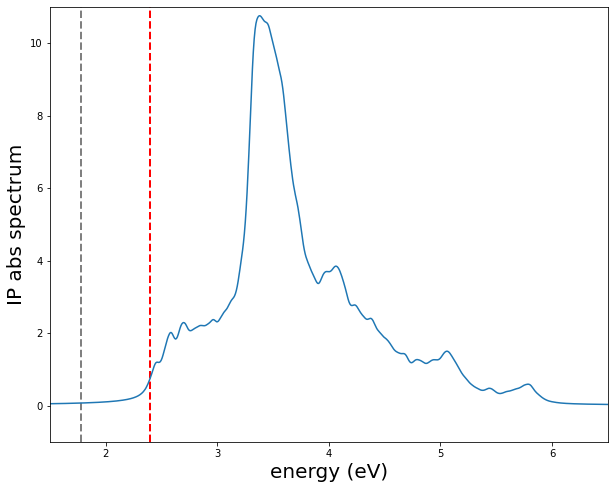

In [21]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(energy,eps_im)
ax.vlines(dft_gap,-1,11,linestyles='--',color='gray',linewidth=2)
ax.vlines(exp_gap,-1,11,linestyles='--',color='red',linewidth=2)
ax.set_ylabel('IP abs spectrum',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.set_xlim(1.5,6.5)
ax.set_ylim(-1,11)

We compute the ip absorption using the -o b option. We include the Coulomb cutoff and we test the usage
of the devel-xuv branch at the ip level

In [5]:
run_dir = 'ABS-IP'
source_dir = 'DFT_analysis/kpoints_42-nbnds_250.save/'
save_dir = Tools.make_p2y(source_dir,overwrite_if_found=False)
Tools.init_yambo_run_dir(save_dir,run_dir=run_dir)

SAVE folder DFT_analysis/kpoints_42-nbnds_250.save/SAVE already present. No operations performed.
SAVE folder already present in ABS-IP. No operations performed.


DFT gap is equal to 1.78 eV, we add a scissor to reproduce the _experimental value_ set to 2.4 eV
in agreemnent with the results of PHYSICAL REVIEW B 88, 045412 (2013)

In [8]:
eta = 0.1 # energy broadening in eV
dft_gap = 1.78
exp_gap = 2.4
scissor = exp_gap-dft_gap # eV
energy_range = [0,8] # eV
energy_step = 1000
bands_trans = [22,29]

inp = I.YamboInput('yambo -r -o b',folder=run_dir)
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_array_variables(LongDrXd = [1.,1.,0.],XfnQP_E=[scissor,1.,1.]) # electric field / scissor
inp.set_array_variables(units='eV',DmRngeXd=[eta/2,eta/2],EnRngeXd=energy_range) # damping / energy range
inp.set_array_variables(ETStpsXd =energy_step, BSEBands=bands_trans,QpntsRXd=[1,1]) # energy step / bands for transitions / momentum transfer
inp

{'args': 'yambo -r -o b',
 'folder': 'ABS-IP',
 'filename': 'yambo.in',
 'arguments': ['rim_cut', 'bse', 'optics', 'photolum'],
 'variables': {'DIP_Threads': [0.0, ''],
  'X_Threads': [0.0, ''],
  'K_Threads': [0.0, ''],
  'RandQpts': [0.0, ''],
  'RandGvec': [1.0, 'RL'],
  'CUTRadius': [0.0, ''],
  'CUTCylLen': [0.0, ''],
  'CUTwsGvec': [0.7, ''],
  'BSENGexx': [116627.0, 'RL'],
  'BEnSteps': [100.0, ''],
  'CUTGeo': 'slab z',
  'BSKmod': 'IP',
  'BSEmod': 'resonant',
  'BSEprop': 'abs',
  'BSEdips': 'none',
  'CUTBox': [[0.0, 0.0, 0.0], ''],
  'BSEQptR': [[1, 1], ''],
  'BSEBands': [[22, 29], ''],
  'BEnRange': [[0.0, 10.0], 'eV'],
  'BDmRange': [[0.1, 0.1], 'eV'],
  'BLongDir': [[1.0, 0.0, 0.0], ''],
  'LongDrXd': [[1.0, 1.0, 0.0], ''],
  'XfnQP_E': [[0.6199999999999999, 1.0, 1.0], ''],
  'DmRngeXd': [[0.05, 0.05], 'eV'],
  'EnRngeXd': [[0, 8], 'eV'],
  'ETStpsXd': [1000, ''],
  'QpntsRXd': [[1, 1], '']}}

In [9]:
name = 'low-energy_abs_Coul-cutoff'
results = code.run(input=inp,run_dir=run_dir,name=name,skip=True)
results

Skip the run of low-energy_abs_Coul-cutoff


{'output': {'eps_q1_IP': 'ABS-IP/low-energy_abs_Coul-cutoff/o-low-energy_abs_Coul-cutoff.eps_q1_IP',
  'eel_q1_IP': 'ABS-IP/low-energy_abs_Coul-cutoff/o-low-energy_abs_Coul-cutoff.eel_q1_IP',
  'alpha_q1_IP': 'ABS-IP/low-energy_abs_Coul-cutoff/o-low-energy_abs_Coul-cutoff.alpha_q1_IP'},
 'report': 'ABS-IP/low-energy_abs_Coul-cutoff/r-low-energy_abs_Coul-cutoff_rim_cut_optics_dipoles_bse',
 'dft': 'ABS-IP/SAVE/ns.db1',
 'cutoff': 'ABS-IP/low-energy_abs_Coul-cutoff/ndb.cutoff',
 'dipoles': 'ABS-IP/low-energy_abs_Coul-cutoff/ndb.dipoles'}

In [13]:
data = P.YamboParser(results)
alpha = data.data['alpha_q1_IP']
energy = alpha['energy'] #['energy']
alpha_im = alpha['alpha_imag'] #['eps_imag']

Text(0.5, 0, 'energy (eV)')

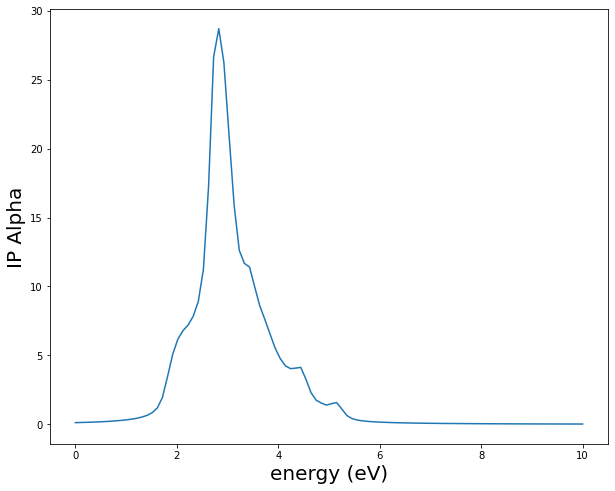

In [14]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(energy,alpha_im)
#ax.vlines(dft_gap,-1,11,linestyles='--',color='gray',linewidth=2)
#ax.vlines(exp_gap,-1,11,linestyles='--',color='red',linewidth=2)
ax.set_ylabel('IP Alpha',size=20)
ax.set_xlabel('energy (eV)',size=20)
#ax.set_xlim(1.5,6.5)
#ax.set_ylim(-1,11)

Now we test xuv feature and we compute the transitions due to the semicore electrons

In [30]:
eta = 0.1 # energy broadening in eV
dft_gap = 1.78
exp_gap = 2.4
scissor = exp_gap-dft_gap # eV
BEnRange = [0,40] # eV
BEnSteps = 1000
BSEBands = [3,28]
BSEHoleBands = [3,8]
BSEElecBands = [27,28]

inp = I.YamboInput('yambo -r -o b',folder=run_dir)
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_array_variables(LongDrXd = [1.,1.,0.],XfnQP_E=[scissor,1.,1.]) # electric field / scissor
inp.set_array_variables(units='eV',BDmRange=[eta/2,eta/2],BEnRange=BEnRange) # damping / energy range
inp.set_array_variables(BSEBands=BSEBands,BSEHoleBands=BSEHoleBands,BSEElecBands=BSEElecBands)
inp.set_array_variables(BEnSteps=BEnSteps,BSEQptR=[1,1]) # energy step / momentum transfer
inp

{'args': 'yambo -r -o b',
 'folder': 'ABS-IP',
 'filename': 'yambo.in',
 'arguments': ['rim_cut', 'bse', 'optics', 'photolum'],
 'variables': {'DIP_Threads': [0.0, ''],
  'X_Threads': [0.0, ''],
  'K_Threads': [0.0, ''],
  'RandQpts': [0.0, ''],
  'RandGvec': [1.0, 'RL'],
  'CUTRadius': [0.0, ''],
  'CUTCylLen': [0.0, ''],
  'CUTwsGvec': [0.7, ''],
  'BSENGexx': [116627.0, 'RL'],
  'BEnSteps': [1000, ''],
  'CUTGeo': 'slab z',
  'BSKmod': 'IP',
  'BSEmod': 'resonant',
  'BSEprop': 'abs',
  'BSEdips': 'none',
  'CUTBox': [[0.0, 0.0, 0.0], ''],
  'BSEQptR': [[1, 1], ''],
  'BSEBands': [[3, 28], ''],
  'BEnRange': [[0, 40], 'eV'],
  'BDmRange': [[0.05, 0.05], 'eV'],
  'BLongDir': [[1.0, 0.0, 0.0], ''],
  'LongDrXd': [[1.0, 1.0, 0.0], ''],
  'XfnQP_E': [[0.6199999999999999, 1.0, 1.0], ''],
  'BSEHoleBands': [[3, 8], ''],
  'BSEElecBands': [[27, 28], '']}}

In [25]:
name = 'xuv-energy_abs'
results = code.run(input=inp,run_dir=run_dir,name=name,skip=False)
results

delete job_out script: ABS-IP/job_xuv-energy_abs.out
delete folder: ABS-IP/xuv-energy_abs
run command: mpirun -np 16 yambo -F xuv-energy_abs.in -J xuv-energy_abs -C xuv-energy_abs
slurm submit:  cd ABS-IP ; sbatch job_xuv-energy_abs.sh
computation xuv-energy_abs is running...
computation xuv-energy_abs ended
Run performed in 59s


{'output': {'eps_q1_IP': 'ABS-IP/xuv-energy_abs/o-xuv-energy_abs.eps_q1_IP',
  'eel_q1_IP': 'ABS-IP/xuv-energy_abs/o-xuv-energy_abs.eel_q1_IP',
  'alpha_q1_IP': 'ABS-IP/xuv-energy_abs/o-xuv-energy_abs.alpha_q1_IP'},
 'report': 'ABS-IP/xuv-energy_abs/r-xuv-energy_abs_rim_cut_optics_dipoles_bse',
 'dft': 'ABS-IP/SAVE/ns.db1',
 'cutoff': 'ABS-IP/xuv-energy_abs/ndb.cutoff',
 'dipoles': 'ABS-IP/xuv-energy_abs/ndb.dipoles'}

In [26]:
data = P.YamboParser(results)
alpha = data.data['alpha_q1_IP']
energy = alpha['energy'] #['energy']
alpha_im = alpha['alpha_imag'] #['eps_imag']

(30.0, 45.0)

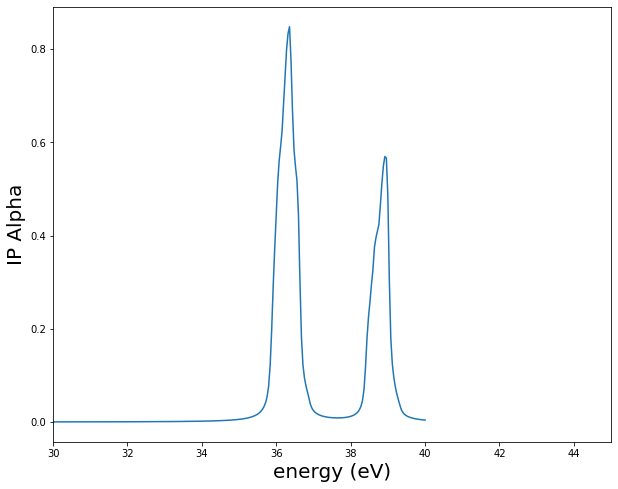

In [28]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(energy,alpha_im)
ax.set_ylabel('IP Alpha',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.set_xlim(30,45)